# Training the SPOCK model

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt

from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian, calc_g0_and_s0
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian

try:
    plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
    pass

In [2]:
import pickle
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
    solar_system_synthetic_theory=pickle.load(fi)

In [3]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
    solar_system_synthetic_theory.masses,
    solar_system_synthetic_theory.semi_major_axes,
    solar_system_synthetic_theory.omega_vector,
    [truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
    [truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [ ]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])
df.head()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbc05c51550>>
Traceback (most recent call last):
  File "/home/miniconda3/envs/lshen/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


evectors, ivectors
relative to the planet
add variance of a, res osc will shift sec

In [ ]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [ ]:
import os
filenames = [f for f in os.listdir("integrations/simulation_files") if os.path.isfile(os.path.join("integrations/simulation_files", f))]
filenames[1][11:16]
Desn = []
for i in range(len(filenames)):
    Desn.append(filenames[i][11:16])

integration_path = Path("integrations/new_ecc_inc_integrations_1")
matched_files = [f for f in integration_path.iterdir() if any(des in f.name for des in Desn)]
rows = []

for i in range(len(matched_files)):
    soln_h = np.load(matched_files[i])
    y = soln_h["y"]
    prope_value = np.average(np.abs((y[9] - 1j * y[0]) / np.sqrt(2)))
    propsini_value = np.average(np.abs((y[1+9] - 1j * y[1]) / np.sqrt(2)))
    des_n = matched_files[i].stem.replace("integration_results_", "")
    rows.append([des_n, prope_value, propsini_value])

df_h = pd.DataFrame(rows, columns=["Des'n", "prope_h", "propsini_h"])

In [ ]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df = pd.merge(merged_df, df_h, on="Des'n", how="inner")
merged_df.shape, labels.shape

((88030, 23), (1249051, 11))

In [ ]:
merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])

In [ ]:
type(merged_df["g0"][0])

numpy.float64

In [ ]:
merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

In [ ]:
merged_df.to_csv("integrations/merged_elements.csv")

In [ ]:
merged_df = pd.read_csv("integrations/merged_elements.csv")
merged_df.columns

Index(['Unnamed: 0', 'Des'n', 'H_x', 'G', 'Epoch', 'M', 'Peri.', 'Node',
       'Incl.', 'e', 'n', 'a', 'propa', 'da', 'prope', 'de', 'propsini',
       'dsini', 'g', 's', 'H_y', 'NumOpps', 'prope_h', 'propsini_h', 'g0',
       'ecospo', 'esinpo', 'sinicosO', 'sinisinO'],
      dtype='object')

In [ ]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0']
data = merged_df[features]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['prope_h']
delsini = merged_df['propsini_h']-np.sin(merged_df['Incl.']*np.pi/180)
delg = merged_df['g0'] - merged_df['g']
s = merged_df['s']

In [ ]:
trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.2, random_state=42)

In [ ]:
trainY.shape

(70424,)

In [ ]:
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

In [ ]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBRegressor(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-rmse-mean"])
    error = np.mean(score["test-rmse-std"])
    
    print("SCORE:", avg_score, "+/-", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can now run an array of different parameter combinations

In [ ]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                
0.031515641505272404                                  
+/-                                                   
0.0007920427564494161                                 
 10%|█         | 1/10 [00:37<05:41, 37.96s/trial, best loss: 0.9684843584947276]

In [ ]:
best

{'x_max_depth': 6.0,
 'x_min_child': 29.027212358902943,
 'x_subsample': 0.9458899808537233}

In [ ]:
model = XGBRegressor(learning_rate = 0.05, 
                         max_depth = 6, 
                         subsample = 0.946,
                         min_child_weight = 29.03)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", verbose_eval=True, num_boost_round=300)

[0]	train-rmse:0.04476+0.00016	test-rmse:0.04476+0.00057
[1]	train-rmse:0.04314+0.00016	test-rmse:0.04317+0.00056
[2]	train-rmse:0.04162+0.00015	test-rmse:0.04167+0.00056
[3]	train-rmse:0.04019+0.00017	test-rmse:0.04025+0.00054
[4]	train-rmse:0.03885+0.00016	test-rmse:0.03893+0.00054
[5]	train-rmse:0.03759+0.00017	test-rmse:0.03770+0.00054
[6]	train-rmse:0.03640+0.00018	test-rmse:0.03653+0.00052
[7]	train-rmse:0.03529+0.00016	test-rmse:0.03544+0.00054
[8]	train-rmse:0.03424+0.00018	test-rmse:0.03442+0.00052
[9]	train-rmse:0.03326+0.00018	test-rmse:0.03346+0.00052
[10]	train-rmse:0.03234+0.00019	test-rmse:0.03256+0.00052
[11]	train-rmse:0.03146+0.00021	test-rmse:0.03171+0.00051
[12]	train-rmse:0.03064+0.00021	test-rmse:0.03092+0.00052


[13]	train-rmse:0.02988+0.00020	test-rmse:0.03019+0.00053
[14]	train-rmse:0.02915+0.00020	test-rmse:0.02949+0.00053
[15]	train-rmse:0.02850+0.00021	test-rmse:0.02886+0.00053
[16]	train-rmse:0.02786+0.00020	test-rmse:0.02826+0.00054
[17]	train-rmse:0.02729+0.00021	test-rmse:0.02771+0.00054
[18]	train-rmse:0.02675+0.00021	test-rmse:0.02719+0.00054
[19]	train-rmse:0.02623+0.00020	test-rmse:0.02670+0.00056
[20]	train-rmse:0.02575+0.00020	test-rmse:0.02626+0.00057
[21]	train-rmse:0.02530+0.00018	test-rmse:0.02584+0.00059
[22]	train-rmse:0.02489+0.00019	test-rmse:0.02545+0.00060
[23]	train-rmse:0.02450+0.00019	test-rmse:0.02509+0.00060
[24]	train-rmse:0.02414+0.00018	test-rmse:0.02474+0.00061
[25]	train-rmse:0.02380+0.00019	test-rmse:0.02443+0.00061
[26]	train-rmse:0.02347+0.00019	test-rmse:0.02413+0.00062
[27]	train-rmse:0.02319+0.00019	test-rmse:0.02386+0.00063
[28]	train-rmse:0.02290+0.00020	test-rmse:0.02359+0.00063
[29]	train-rmse:0.02264+0.00020	test-rmse:0.02335+0.00063
[30]	train-rms

# n_estimators (number of trees) tuning

Text(0, 0.5, 'CV AUC score')

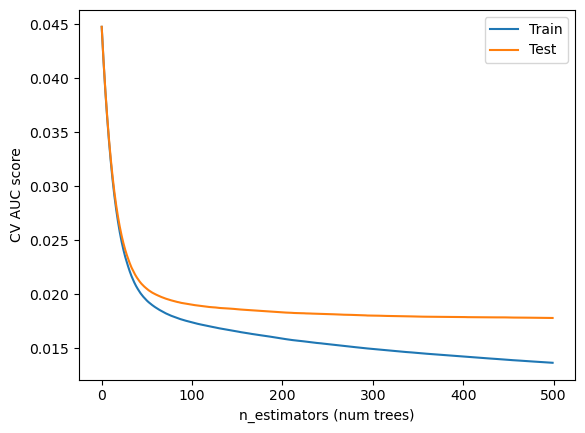

In [ ]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

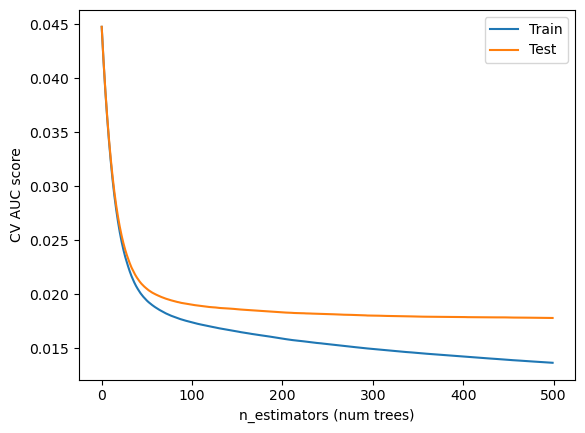

In [ ]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
ax.set_ylim(0.01, 0.46)
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

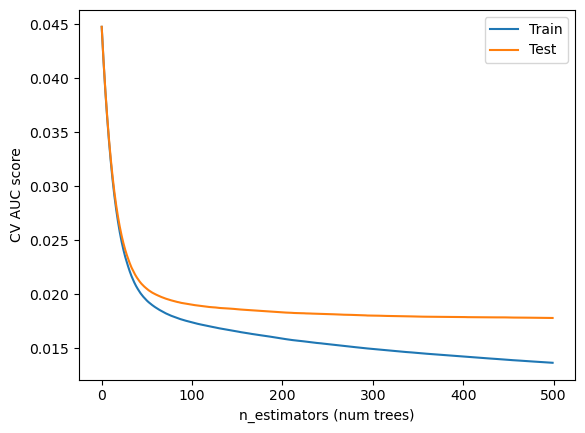

In [ ]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

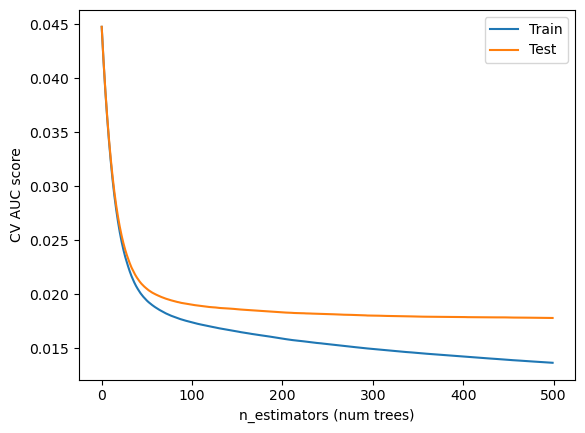

In [ ]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

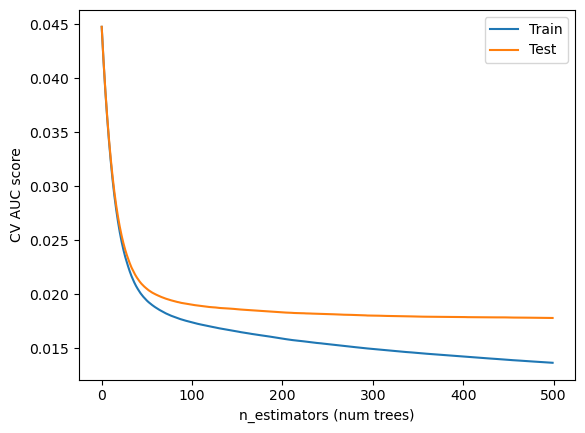

In [ ]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [ ]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model= xgb.train(dtrain=dtrain, params=model.get_params(), num_boost_round=2000)

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [05:12:18] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
%%time
pred = model.predict(dtest)

CPU times: user 2.78 s, sys: 178 ms, total: 2.96 s
Wall time: 72.7 ms


In [ ]:
np.std(pred-testY)

0.038729001849892544

Text(0.5, 0, 'Prop e')

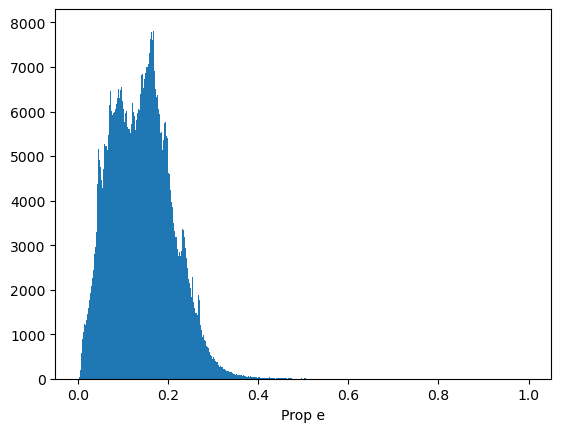

In [ ]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(labels['prope'], bins=np.linspace(0, 1, 1000))
ax.set_xlabel('Prop e')

Text(0.5, 0, 'Nesvorny Proper Eccentricity Correction')

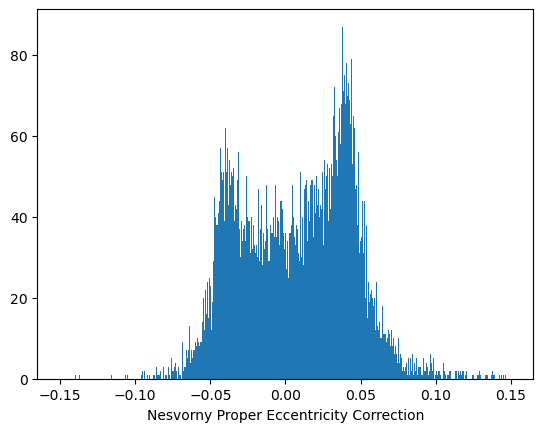

In [ ]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Nesvorny Proper Eccentricity Correction')

Text(0.5, 0, 'Correction Error (Model-Nesvorny)')

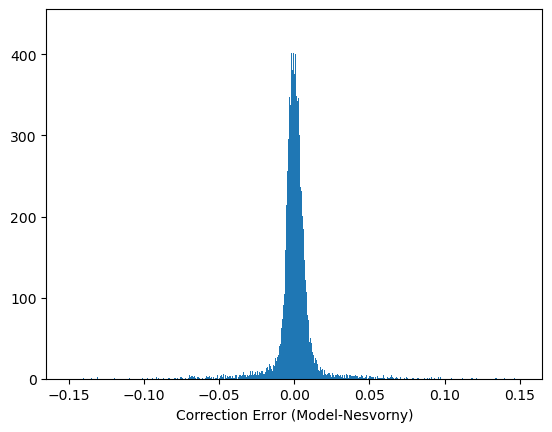

In [ ]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')


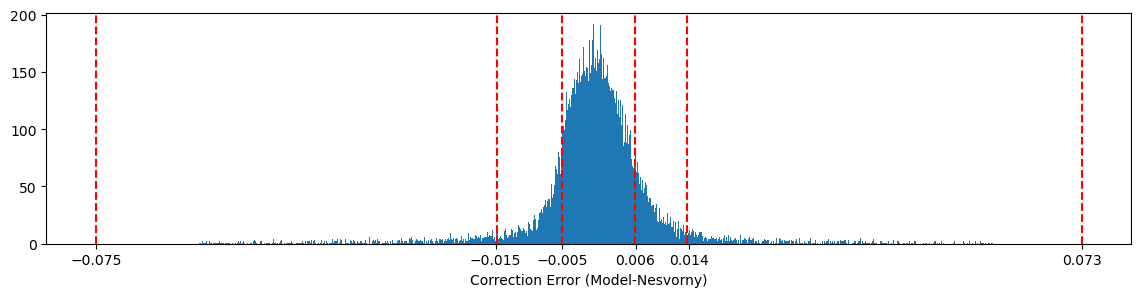

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

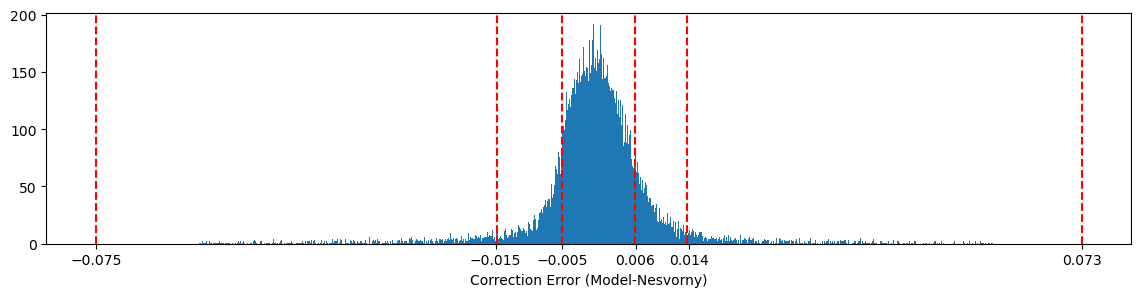

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

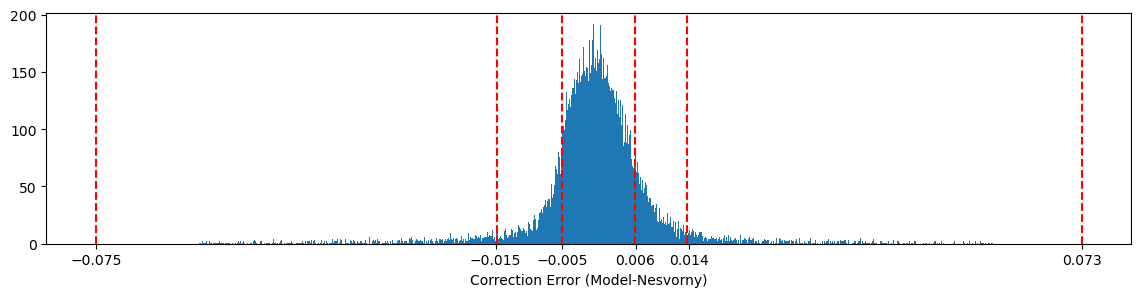

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

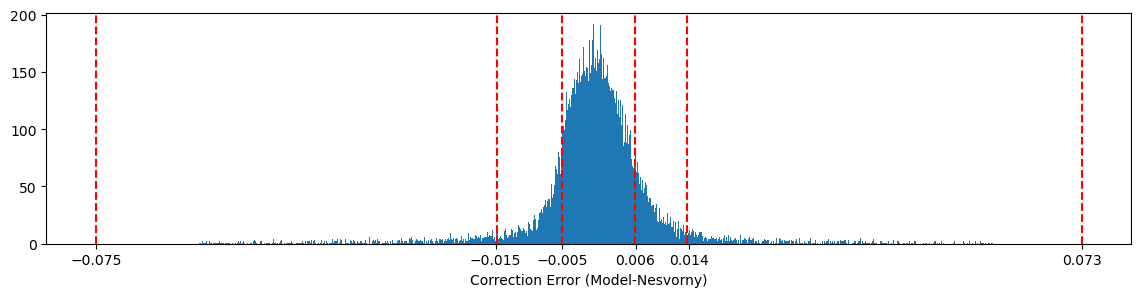

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

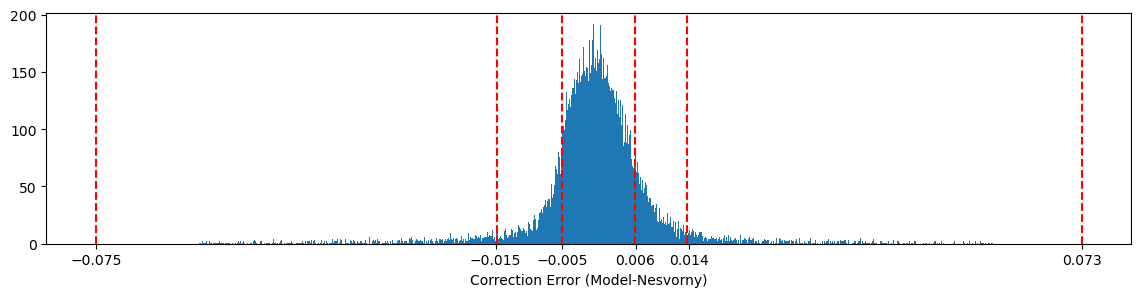

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

In [ ]:
(pred-testY).min()

-3.353646627857235

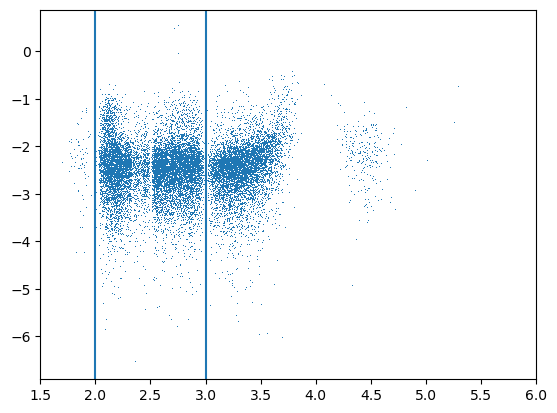

In [ ]:
aJup = 5.202263784717109
fig, ax = plt.subplots()
ax.plot((aJup/testX['propa'])**(3/2), np.log10(np.abs(pred-testY)), ',')
ax.set_xlim([1.5, 6])
ax.axvline(2)
ax.axvline(3)

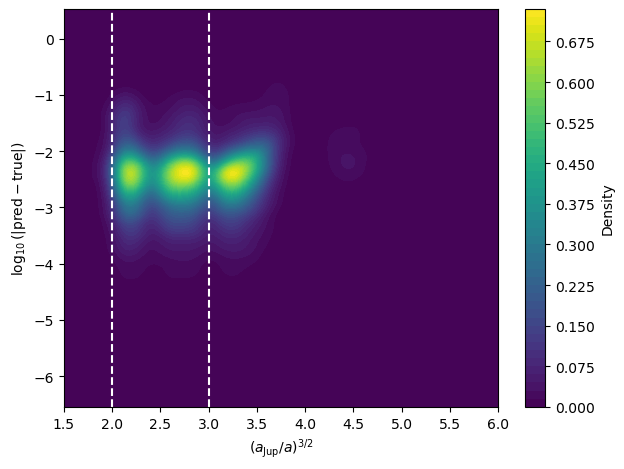

In [ ]:
from scipy.stats import gaussian_kde

# Compute your X and Y data
x = (aJup / testX['propa'])**(3/2)
y = np.log10(np.abs(pred - testY))

# Stack the data for KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the plot range
xgrid = np.linspace(1.5, 6, 200)
ygrid = np.linspace(np.min(y), np.max(y), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot
fig, ax = plt.subplots()
contour = ax.contourf(Xgrid, Ygrid, Z, levels=50, cmap='viridis')
ax.set_xlim([1.5, 6])
ax.axvline(2, color='white', linestyle='--')
ax.axvline(3, color='white', linestyle='--')
fig.colorbar(contour, ax=ax, label='Density')
ax.set_xlabel(r'$(a_\mathrm{Jup} / a)^{3/2}$')
ax.set_ylabel(r'$\log_{10}(|\mathrm{pred} - \mathrm{true}|)$')
plt.tight_layout()
plt.show()